<a href="https://colab.research.google.com/github/leehyunggeunkeun/pytorch-study/blob/master/pytorch_0504_%EC%9D%B8%EA%B3%B5%EC%8B%A0%EA%B2%BD%EB%A7%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

저번주와 동일한 FMNIST 데이터셋으로  소프트맥스방법이 아니라
여러개의 층을 쌓는 인공신경망으로 테스트를 해보겠습니다

층을 제외한 기타 하이퍼파라미터 값들은 동일

In [0]:
#필요 라이브러리

#기본 
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision.datasets as dsets #데이터셋 불러오기
import torchvision.transforms as transforms #데이터 전처리
from torch.utils.data import DataLoader #데이터 로더시에 필요
import matplotlib.pyplot as plt #시각화

In [2]:
#이미지라서 오래걸리니 gpu사용하자

USE_CUDA = torch.cuda.is_available() # GPU를 사용가능하면 True, 아니라면 False를 리턴
device = torch.device("cuda" if USE_CUDA else "cpu") # GPU 사용 가능하면 사용하고 아니면 CPU 사용
print("다음 기기로 학습합니다:", device)

다음 기기로 학습합니다: cuda


In [0]:
torch.manual_seed(1)
if device == 'cuda':
    torch.cuda.manual_seed_all(1)

In [4]:
#데이터셋 불러오기

trans = transforms.Compose([transforms.ToTensor(),
transforms.Normalize((0.5,), (0.5,))])  #compose 는 이미지 관련 전처리를 한곳에서 묶어서 할 수 있게 해주는 기능, 데이터 로드시 transform에 변수값만 입력해주면 된다

train_data = dsets.FashionMNIST('./data', train=True, transform=trans, download=True)

test_data = dsets.FashionMNIST('./data', train=False, transform=trans, download=True)

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [5]:
#train_data를 8:2로 train_dataset와 val_dataset으로 나눔

train_val_ratio = 0.8
train_size = int(len(train_data) * train_val_ratio)
val_size = len(train_data) - train_size

# train set와 validation set로 나누자

train_dataset, val_dataset = torch.utils.data.random_split(train_data, [train_size, val_size])
print(len(train_dataset), len(val_dataset))

48000 12000


In [0]:
learning_rate = 0.01
batch_size=64

In [0]:
train_loader=DataLoader(dataset=train_dataset,batch_size=batch_size,shuffle=True,drop_last=True)
val_loader=DataLoader(dataset=val_dataset,batch_size=batch_size,shuffle=True,drop_last=True) 
test_loader=DataLoader(dataset=test_data,batch_size=batch_size,shuffle=False,drop_last=True)

단층 레이어

In [0]:
class Fmnist1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer=nn.Sequential(
            nn.Linear(784,10)
           
        )

    def forward(self,x):
        x=x.view(x.size(0),-1)
        x=self.layer(x)
        return x

In [0]:
#relu 함수이니까 he정규화 한번 해보자

def weights_init(m):
    if isinstance(m, nn.Linear): # 모델의 모든 MLP 레이어에 대해서
        nn.init.kaiming_normal_(m.weight) # Weight를 he_normal로 초기화
        print(m.weight)

In [10]:
model1=Fmnist1().to(device)
model1.apply(weights_init)


Parameter containing:
tensor([[-0.0150,  0.1352, -0.0071,  ...,  0.0113,  0.0085, -0.0496],
        [ 0.0039,  0.0253, -0.0591,  ...,  0.0631, -0.0273,  0.0277],
        [ 0.0905,  0.0936, -0.0038,  ...,  0.0043, -0.0216, -0.0667],
        ...,
        [-0.0814,  0.0138,  0.0115,  ..., -0.0393,  0.0366, -0.1038],
        [-0.0645, -0.0775, -0.0344,  ..., -0.0236, -0.0331, -0.0384],
        [-0.0559, -0.0191,  0.0325,  ..., -0.0170,  0.0567, -0.0339]],
       device='cuda:0', requires_grad=True)


Fmnist1(
  (layer): Sequential(
    (0): Linear(in_features=784, out_features=10, bias=True)
  )
)

In [0]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model1.parameters(),lr=learning_rate)

In [12]:
total_batch=len(train_loader)+len(val_loader)

train_losses = []
val_losses = []

epochs=10

for epoch in range(epochs+1):
    avg_cost=0
    for i,data in enumerate(train_loader):
        imgs,labels=data
        imgs=imgs.to(device)
        labels=labels.to(device)

        optimizer.zero_grad()
        hypothesis=model1(imgs)
        cost=criterion(hypothesis,labels)
        cost.backward()
        optimizer.step()
        train_losses.append(cost.item())


        avg_cost += cost/total_batch

    print('epoch:{} cost= {}'.format(epoch+1,avg_cost))

    for i,data in enumerate(val_loader):
        imgs,labels=data
        imgs=imgs.to(device)
        labels=labels.to(device)

        optimizer.zero_grad()
        hypothesis=model1(imgs)
        cost=criterion(hypothesis,labels)
        cost.backward()
        optimizer.step()
        val_losses.append(cost.item())


        avg_cost += cost/total_batch

    print('epoch:{} cost= {}'.format(epoch+1,avg_cost))
    print('-'*50)

epoch:1 cost= 0.5623453259468079
epoch:1 cost= 0.7011311054229736
--------------------------------------------------
epoch:2 cost= 0.5302460193634033
epoch:2 cost= 0.6602708697319031
--------------------------------------------------
epoch:3 cost= 0.5255603194236755
epoch:3 cost= 0.6638447642326355
--------------------------------------------------
epoch:4 cost= 0.5293907523155212
epoch:4 cost= 0.660694420337677
--------------------------------------------------
epoch:5 cost= 0.5364067554473877
epoch:5 cost= 0.6650168299674988
--------------------------------------------------
epoch:6 cost= 0.5056276321411133
epoch:6 cost= 0.6477472186088562
--------------------------------------------------
epoch:7 cost= 0.5310006737709045
epoch:7 cost= 0.6586558222770691
--------------------------------------------------
epoch:8 cost= 0.529986560344696
epoch:8 cost= 0.6738790273666382
--------------------------------------------------
epoch:9 cost= 0.5112943649291992
epoch:9 cost= 0.6422080397605896


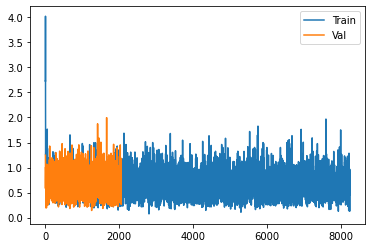

In [13]:
plt.plot(train_losses,label='Train')
plt.plot(val_losses,label='Val')
plt.legend()
plt.show()

In [14]:
with torch.no_grad():
    correct=0
    total=0
    
    for i,data in enumerate(test_loader):
        imgs,labels=data
        imgs=imgs.to(device)
        labels=labels.to(device)

        prediction=model1(imgs)
        _,argmax= torch.max(prediction,1)
        total += imgs.size(0)
        correct += (labels == argmax).sum().item()
    
    print('Test accuracy for {} images: {:.2f}%'.format(total, correct / total * 100))

Test accuracy for 9984 images: 79.86%


다층 레이어

In [0]:
class Fmnist2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1=nn.Sequential(
            nn.Linear(784,512),
            nn.BatchNorm1d(512),     #batchnorm해보자 output 10개를 따라가는 듯??
            nn.ReLU()
        )


        self.layer2=nn.Sequential(
            nn.Linear(512,128),
            nn.BatchNorm1d(128),
            nn.ReLU()
        )

        self.layer3= nn.Sequential(
            
            nn.Linear(128,10)    #마지막 레이어는 Linear 까지만 적용....
        )

    def forward(self,x):
        x=x.view(x.size(0),-1)
        x=self.layer1(x)
        x=self.layer2(x)
        x=self.layer3(x)
        
        return x

In [16]:
# 마찬가지로 he 정규화 적용
model2=Fmnist2().to(device)
model2.apply(weights_init)

Parameter containing:
tensor([[-0.0320, -0.0325, -0.0324,  ...,  0.0478, -0.0152, -0.0555],
        [ 0.0889,  0.0222,  0.0421,  ...,  0.0234,  0.0195, -0.0266],
        [-0.0615,  0.0356, -0.0479,  ...,  0.0351, -0.0971, -0.0217],
        ...,
        [-0.0677,  0.0495, -0.0305,  ...,  0.0618, -0.0014,  0.0650],
        [ 0.0704, -0.0445, -0.0338,  ..., -0.0403, -0.0041, -0.0740],
        [ 0.0915, -0.0360, -0.0259,  ..., -0.1140, -0.0644, -0.0016]],
       device='cuda:0', requires_grad=True)
Parameter containing:
tensor([[-0.0363, -0.0639,  0.0521,  ..., -0.0414,  0.0215,  0.1177],
        [-0.0248,  0.0969,  0.0338,  ...,  0.1077,  0.0251,  0.0268],
        [ 0.0751,  0.0806,  0.0748,  ..., -0.1414,  0.0566,  0.0168],
        ...,
        [ 0.0460, -0.0424,  0.0345,  ...,  0.0569, -0.0572, -0.0162],
        [ 0.0079, -0.0300, -0.0060,  ..., -0.0299,  0.0588, -0.0025],
        [-0.0494, -0.0337, -0.0637,  ...,  0.0880, -0.0481, -0.0409]],
       device='cuda:0', requires_grad=True)


Fmnist2(
  (layer1): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer2): Sequential(
    (0): Linear(in_features=512, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer3): Sequential(
    (0): Linear(in_features=128, out_features=10, bias=True)
  )
)

In [0]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model2.parameters(),lr=learning_rate)

In [18]:
total_batch=len(train_loader)+len(val_loader)

train_losses = []
val_losses = []

epochs=10

for epoch in range(epochs+1):
    avg_cost=0
    for i,data in enumerate(train_loader):
        imgs,labels=data
        imgs=imgs.to(device)
        labels=labels.to(device)

        optimizer.zero_grad()
        hypothesis=model2(imgs)
        cost=criterion(hypothesis,labels)
        cost.backward()
        optimizer.step()
        train_losses.append(cost.item())


        avg_cost += cost/total_batch

    print('epoch:{} cost= {}'.format(epoch+1,avg_cost))

    for i,data in enumerate(val_loader):
        imgs,labels=data
        imgs=imgs.to(device)
        labels=labels.to(device)

        optimizer.zero_grad()
        hypothesis=model2(imgs)
        cost=criterion(hypothesis,labels)
        cost.backward()
        optimizer.step()
        val_losses.append(cost.item())


        avg_cost += cost/total_batch

    print('epoch:{} cost= {}'.format(epoch+1,avg_cost))
    print('-'*50)

epoch:1 cost= 0.3793409764766693
epoch:1 cost= 0.4602895677089691
--------------------------------------------------
epoch:2 cost= 0.29137077927589417
epoch:2 cost= 0.36038970947265625
--------------------------------------------------
epoch:3 cost= 0.2595446705818176
epoch:3 cost= 0.32144874334335327
--------------------------------------------------
epoch:4 cost= 0.23940050601959229
epoch:4 cost= 0.2987751364707947
--------------------------------------------------
epoch:5 cost= 0.22157767415046692
epoch:5 cost= 0.27512937784194946
--------------------------------------------------
epoch:6 cost= 0.210440993309021
epoch:6 cost= 0.26116493344306946
--------------------------------------------------
epoch:7 cost= 0.19702351093292236
epoch:7 cost= 0.24510128796100616
--------------------------------------------------
epoch:8 cost= 0.1896527260541916
epoch:8 cost= 0.2362447828054428
--------------------------------------------------
epoch:9 cost= 0.18027463555335999
epoch:9 cost= 0.223890

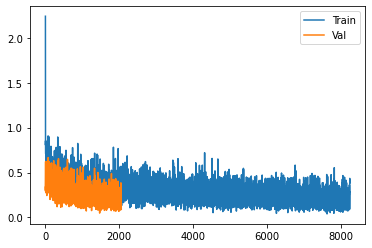

In [19]:
plt.plot(train_losses,label='Train')
plt.plot(val_losses,label='Val')
plt.legend()
plt.show()

In [20]:
with torch.no_grad():
    correct=0
    total=0
    
    for i,data in enumerate(test_loader):
        imgs,labels=data
        imgs=imgs.to(device)
        labels=labels.to(device)

        prediction=model2(imgs)
        _,argmax= torch.max(prediction,1)
        total += imgs.size(0)
        correct += (labels == argmax).sum().item()
    
    print('Test accuracy for {} images: {:.2f}%'.format(total, correct / total * 100))

Test accuracy for 9984 images: 88.70%


층도 2개 더 쌓고 배치정규화도 추가해주긴 했지만 확실히 효과가 좋다!!
저번주 소프트맥스는 79.86%